In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas_datareader as web
import math
import yfinance as yf
import pandas as pd
import seaborn as sns

In [2]:
from keras import Input
from keras import layers
from tensorflow.keras.optimizers import RMSprop
import random

In [3]:
import sys
sys.path.append('../..')

#import ep.etools as apt

In [4]:
dataCalendar = pd.read_csv('./data/bloc_ttf_calendar_prices.csv')
dataPrices = pd.read_csv('./data/bloc_ttf_prices.csv')
dataPrices[' '] = pd.to_datetime(dataPrices[' '])
dataPrices = dataPrices.set_index(' ')


In [5]:
dataPrices['moy20'] = dataPrices['Day-ahead'].rolling(20).mean()

<Axes: xlabel=' '>

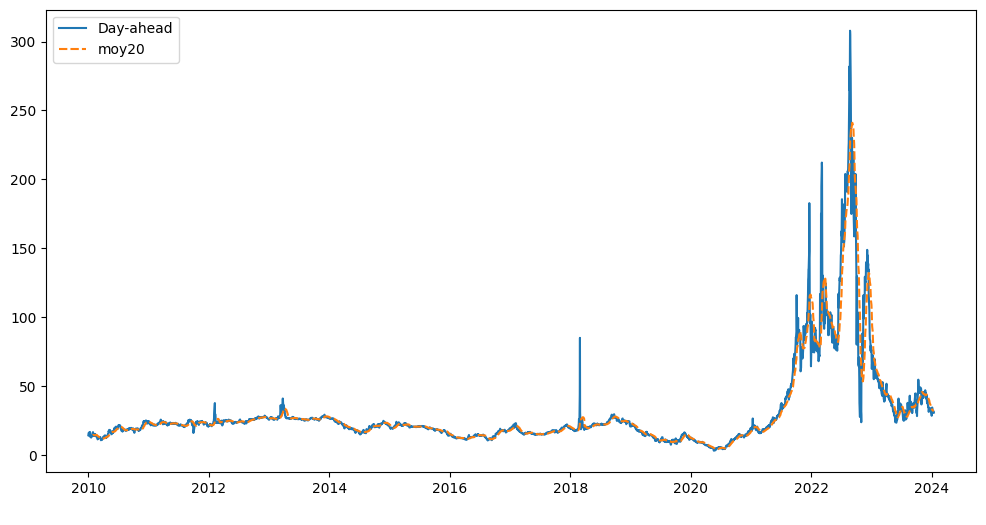

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(dataPrices[['Day-ahead','moy20']], color='Blue')
#ax2 = plt.twinx()
#sns.lineplot(data=final['€/$'], ax=ax2 , color='grey')

<Axes: xlabel=' '>

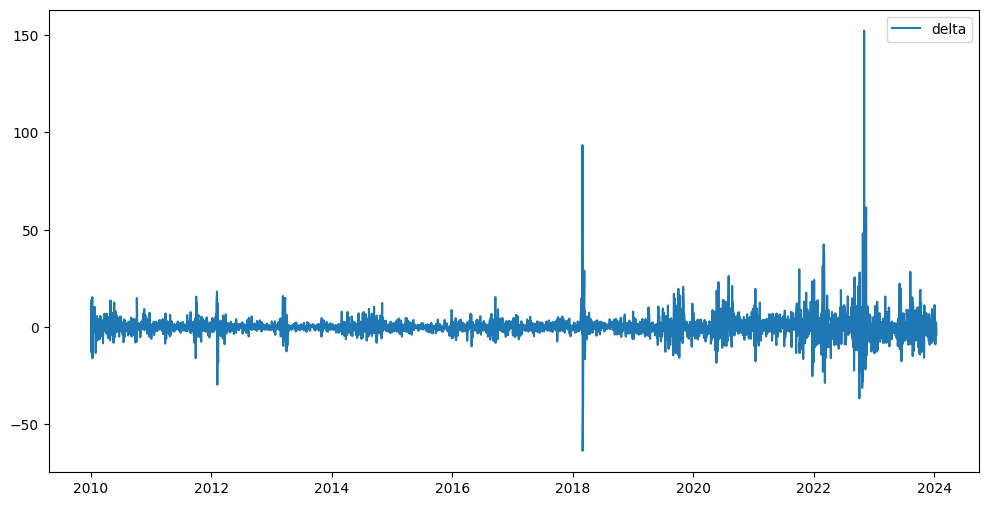

In [7]:
#Variation en %
dataPrices['delta'] =dataPrices['Day-ahead'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0])/x.iloc[0]*100)
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(dataPrices[['delta']], color='Blue')


In [8]:
std = dataPrices['delta'].std()
max = dataPrices['delta'].max()
inc = std/10.
print(std,max)

6.0295968222450105 152.31286795626576


<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, -152.01138811515352 to 151.88029172599866
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       505 non-null    int64  
 1   freq    505 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.8 KB
None


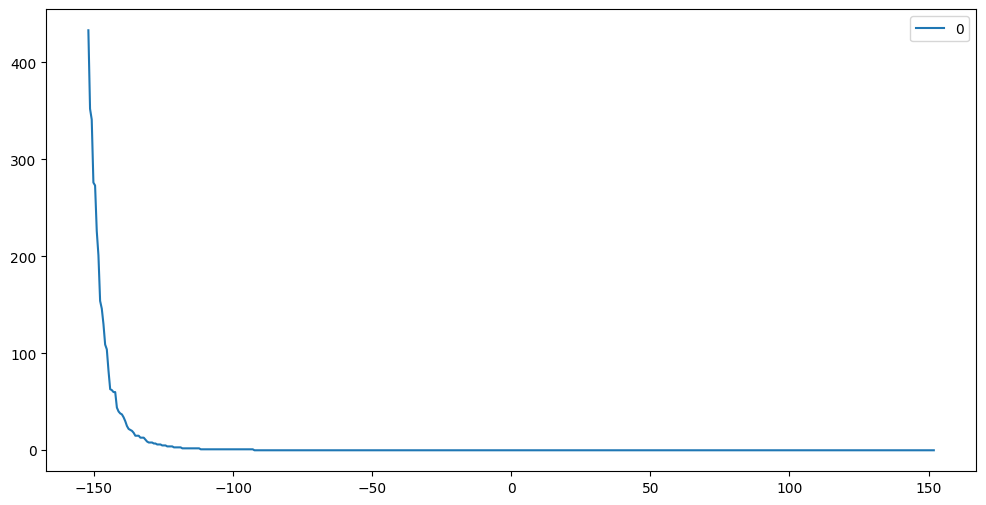

In [26]:
#df= dataPrices['delta'].value_counts(bins=100)
# create intervals

bins = pd.interval_range(-max, max, freq=inc)
# assign each value in df["column"] to bin and count bin occurences
counts = pd.cut(dataPrices['delta'], bins).value_counts()
# print(counts.info)
# create a Series, indexed by interval midpoints and convert to dictionary
pdS = pd.Series(counts.values, index=bins.mid).to_frame()   #.to_dict()
fig, ax = plt.subplots(figsize=(12,6))
#plt.yscale('log')
#plt.xscale('log')
sns.lineplot(pdS, color='Grey')
pdS['freq'] = pdS.index.values
print(pdS.info())

In [27]:
distribution = pdS
distribution = distribution.rename(columns={0:'val'})
# distribution['freq'] = (bins.mid)
distribution['cumul'] = distribution['val'].cumsum(skipna=True)
distribution.reset_index(drop=True,inplace=True)
print(distribution.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   val     505 non-null    int64  
 1   freq    505 non-null    float64
 2   cumul   505 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 12.0 KB
None


0     -152.011388
1     -151.408428
2     -150.805469
3     -150.202509
4     -149.599549
          ...    
500    149.468453
501    150.071413
502    150.674372
503    151.277332
504    151.880292
Name: freq, Length: 505, dtype: float64


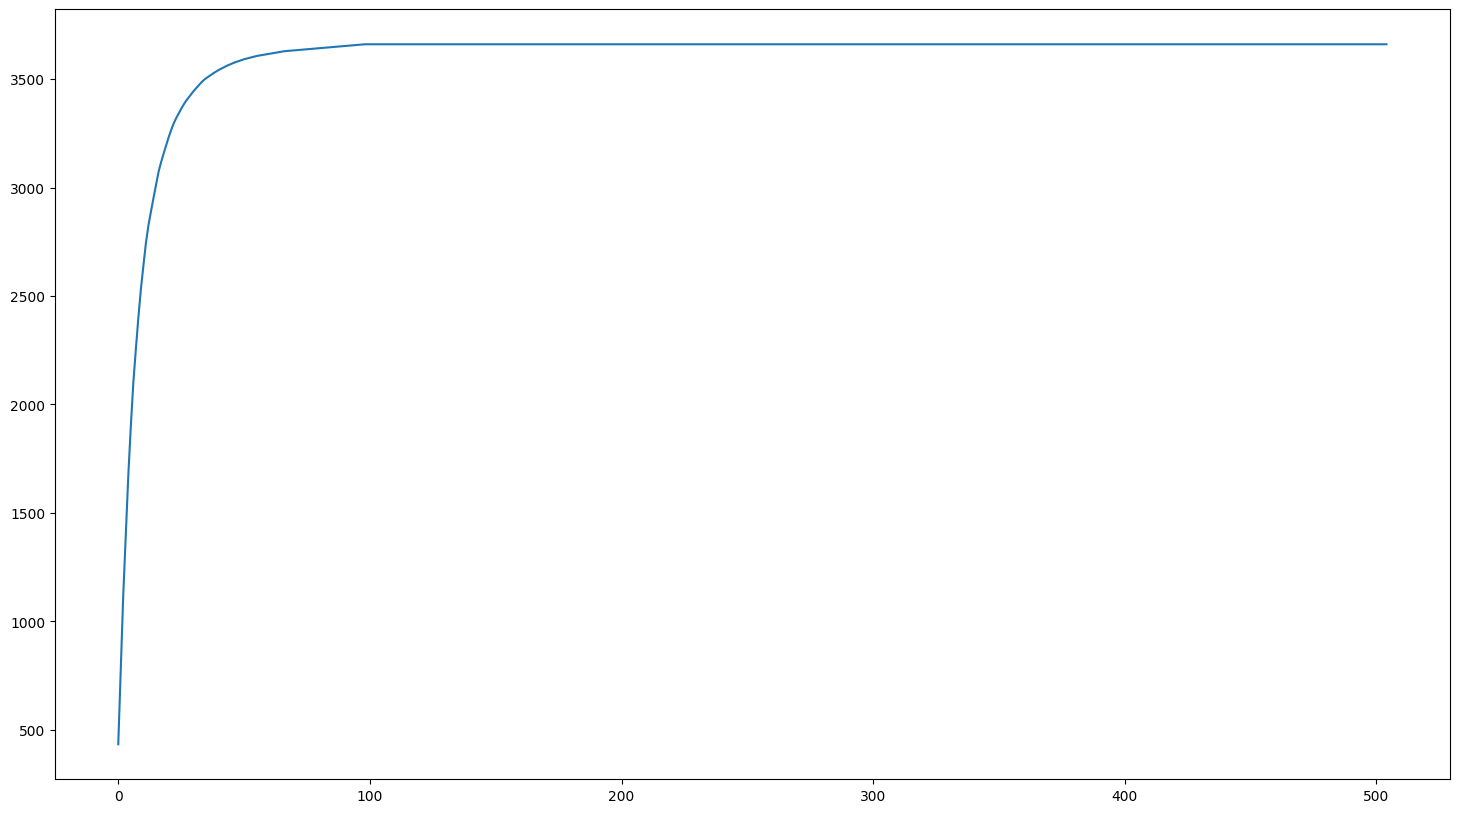

In [28]:
print(distribution.freq)
fig=plt.figure(figsize=(18,10))
plt.plot(distribution['cumul'])

In [29]:
s = distribution['val'].values[0]
m = distribution['val'].sum()
r = random.randint(0,1700)
min = distribution.index[0]
print(r, m, s)
v = distribution['cumul'].loc[lambda x: x>=r].index.min()
print(v)

675 3661 433
1


In [30]:
def getRandomValue(df,crit,val,ref):
    nb = df[val].count()
    max = df[crit].max()
    r = (np.random.uniform(0,max))
    #print(r,max)
    id = df[crit].loc[lambda x: x>=r].index.min()
    if (id>0):
        v = (df[val][id]-df[val][id-1])*(r-df[crit][id-1])/df[ref][id] + df[val][id-1]
    else:
        v = (df[val][id])*r/df[ref][id]
    #print(nb,v,id)
    return v

In [70]:
getRandomValue(distribution,'cumul','freq','val')

-144.28392176134128

In [71]:
simul = np.ones(10)
for i in range(10):
    simul[i] = (getRandomValue(distribution,'cumul','freq','val'))
    
print(simul)

[-147.36438895 -148.32541116 -147.34228244 -141.42902658  -56.34753104
 -147.9584493  -151.43964192  -22.02126877 -149.27541606 -150.92129167]


In [15]:
#distribution.reset_index(drop=True,inplace=True)
#distribution.set_index()
distribution

,val,freq,cumul
0,346,0.301480,346
1,299,0.904440,645
2,238,1.507399,883
3,164,2.110359,1047
4,141,2.713319,1188
...,...,...,...
247,0,149.232521,1769
248,0,149.835481,1769
249,0,150.438441,1769
250,0,151.041400,1769
